Calculating Wind Shear
======================

This example plots calculates the 850-500 hPa Bulk Wind Shear

Plotting over a regional domain, accessing the Best Collection of GFS from the
Unidata Thredds server, plots MSLP (hPa), 850-hPa Wind Vector (m/s), 500-hPa
Wind Vector (m/s), and the Wind Shear between the two layers (m/s)

Import necessary packages and obtain data

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

Helper function for finding proper time variable

In [2]:
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

Obtain data

In [3]:
# Construct a TDSCatalog instance pointing to the gfs dataset
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                      'NCEP/GFS/Global_0p5deg/catalog.xml')

# Pull out the dataset you want to use and look at the access URLs
best_ds = list(best_gfs.datasets.values())[1]
print(best_ds.access_urls)

# Create NCSS object to access the NetcdfSubset
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])
print(best_ds.access_urls['NetcdfSubset'])

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best', 'WCS': 'https://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best', 'WMS': 'https://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best', 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best', 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best', 'NCML': 'https://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best', 'UDDC': 'https://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best', 'ISO': 'https://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best'}
https://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best


First Query for MSLP

In [4]:
# Create lat/lon box for location you want to get data for
query = ncss.query()
query.lonlat_box(north=50, south=30, east=-80, west=-115).time(datetime.utcnow())
query.accept('netcdf4')

# Request data for MSLP
query.variables('MSLP_Eta_model_reduction_msl')
data = ncss.get_data(query)

# Pull out the variables you want to use
mslp_var = data.variables['MSLP_Eta_model_reduction_msl']
time_var = data.variables[find_time_var(mslp_var)]
lat_var = data.variables['lat']
lon_var = data.variables['lon']

Second Query for 850-hPa data

In [5]:
# Request data for 850-hPa winds
# First clear the query's variables from previous query for MSLP
query.var = set()
query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(85000)
data = ncss.get_data(query)
u_wind_var850 = data.variables['u-component_of_wind_isobaric']
v_wind_var850 = data.variables['v-component_of_wind_isobaric']

Third Query for 500-hPa data

In [6]:
# Request data for 500-hPa winds
# First clear the query's variables from previous query for 850-hPa data
query.var = set()
query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(50000)
data = ncss.get_data(query)
u_wind_var500 = data.variables['u-component_of_wind_isobaric']
v_wind_var500 = data.variables['v-component_of_wind_isobaric']

Data Manipulation

In [7]:
# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
mslp = units.Quantity(mslp_var[:].squeeze(), mslp_var.units).to('hPa')
u_wind850 = u_wind_var850[:].squeeze()
v_wind850 = v_wind_var850[:].squeeze()
u_wind500 = u_wind_var500[:].squeeze()
v_wind500 = v_wind_var500[:].squeeze()

# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth mslp data
mslp = ndimage.gaussian_filter(mslp, sigma=3, order=0)

Begin making figure

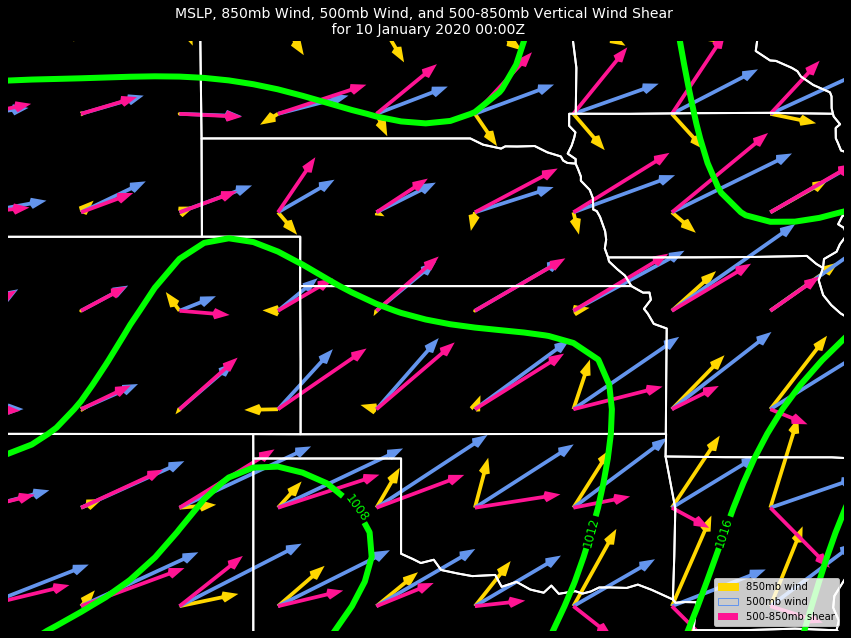

In [8]:
# Create new figure
fig = plt.figure(figsize=(15, 12), facecolor='black')

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-108., -91., 33., 45.])
ax.background_patch.set_fill(False)

# Add state boundaries to plot
ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=2)

# Contour the MSLP
c = ax.contour(lon_2d, lat_2d, mslp, colors='lime', linewidths=6)
ax.clabel(c, fontsize=12, inline=1, inline_spacing=4, fmt='%i')

wslice = slice(1, None, 4)
# Plot 850-hPa wind vectors
vectors850 = ax.quiver(lon_2d[wslice, wslice], lat_2d[wslice, wslice],
                       u_wind850[wslice, wslice], v_wind850[wslice, wslice],
                       headlength=4, headwidth=3, angles='xy', scale_units='xy',
                       scale=12, color='gold', label='850mb wind')

# Plot 500-hPa wind vectors
vectors500 = ax.quiver(lon_2d[wslice, wslice], lat_2d[wslice, wslice],
                       u_wind500[wslice, wslice], v_wind500[wslice, wslice],
                       headlength=4, headwidth=3, angles='xy', scale_units='xy',
                       scale=12, color='cornflowerblue', label='500mb wind')

# Plot 500-850 shear
shear = ax.quiver(lon_2d[wslice, wslice], lat_2d[wslice, wslice],
                  u_wind500[wslice, wslice] - u_wind850[wslice, wslice],
                  v_wind500[wslice, wslice] - v_wind850[wslice, wslice],
                  headlength=4, headwidth=3, angles='xy', scale_units='xy',
                  scale=12, color='deeppink', label='500-850mb shear')

# Add a legend
ax.legend(('850mb wind', '500mb wind', '500-850mb shear'), loc=4)

# Manually set colors for legend
legend = ax.get_legend()
legend.legendHandles[0].set_color('gold')
legend.legendHandles[1].set_color('cornflowerblue')
legend.legendHandles[2].set_color('deeppink')

# Add a title to the plot
plt.title('MSLP, 850mb Wind, 500mb Wind, and 500-850mb Vertical Wind Shear \n'
          ' for {0:%d %B %Y %H:%MZ}'.format(time), color='white', size=14);